In [1]:
import random
from collections import namedtuple, deque
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
import gymnasium
import torchvision.models as models
from PIL import Image, ImageDraw
import os
import copy 
import cv2
from glob import glob
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-4 #скорость обучения CNN
NUM_CLASSES = 10
IMG_SIZE = 128
NUM_IMAGES = 50000
MAX_SUBSET_SIZE = 1000 #количество изображений в выборке
CNN_EPOCHS = 1

EPS_START = 0.9#стартовое значение epsilon для e-greedy стратегии
EPS_END = 0.05#конечное значение
EPS_DECAY = 200 #скорость изменения epsilon
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)  
print(torch.backends.cudnn.is_available()) 
print(torch.__version__) 



None
False
2.6.0+cpu


In [ ]:
class AdvancedBloodCellGenerator:
    def __init__(self,
                 target_img_size=(IMG_SIZE, IMG_SIZE), # Размер изображения на выходе
                 cell_patch_dir='./data/train/cells',
                 background_patch_dir='./data/train/background',
                 num_cells_range=(1, NUM_CLASSES) # Диапазон кол-ва клеток (1-10)
                 ):
        self.target_img_size = target_img_size
        self.cell_patch_dir = cell_patch_dir
        self.background_patch_dir = background_patch_dir
        self.num_cells_range = num_cells_range # Используем адаптированный диапазон

        # Проверяем наличие папок с патчами
        if not os.path.exists(self.cell_patch_dir) or not glob(os.path.join(self.cell_patch_dir, "*.png")):
             raise FileNotFoundError(f"Папка с патчами клеток '{self.cell_patch_dir}' не найдена или пуста. Запустите скрипт нарезки патчей.")
        if not os.path.exists(self.background_patch_dir) or not glob(os.path.join(self.background_patch_dir, "*.png")):
             raise FileNotFoundError(f"Папка с патчами фона '{self.background_patch_dir}' не найдена или пуста. Запустите скрипт нарезки патчей.")

        self.background_patch_files = glob(os.path.join(self.background_patch_dir, "*.png"))
        self.cell_patch_files = glob(os.path.join(self.cell_patch_dir, "*.png"))
        # Размер патчей фона (предполагаем, что все одинаковые)
        patch_sample = cv2.imread(self.background_patch_files[0])
        if patch_sample is None:
             raise ValueError(f"Не удалось прочитать пример патча фона: {self.background_patch_files[0]}")
        self.patch_size = patch_sample.shape[:2] # (height, width)


    # Внутри класса AdvancedBloodCellGenerator:

    def _create_background_from_patches(self):
        """
        Создает фон, растягивая ОДИН случайный фоновый патч
        до целевого размера изображения.
        """
        if not self.background_patch_files:
            print("Warning: Список фоновых патчей пуст! Создаем серый фон.")
            background = np.full((self.target_img_size[1], self.target_img_size[0], 3), 128, dtype=np.uint8)
            return background

        background = None # Инициализируем как None
        attempts = 0
        max_attempts = 10 # Попробуем несколько раз, если патч не читается

        while background is None and attempts < max_attempts:
            attempts += 1
            patch_path = random.choice(self.background_patch_files)
            patch = cv2.imread(patch_path)

            if patch is None:
                print(f"Warning: Попытка {attempts}/{max_attempts}. Не удалось прочитать фоновый патч {patch_path}. Пробуем другой.")
                continue # Переходим к следующей попытке

            # Проверка и конвертация в BGR (оставляем из предыдущего исправления)
            if patch.ndim == 2:
                patch = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
            elif patch.ndim == 3 and patch.shape[2] == 4:
                patch = cv2.cvtColor(patch, cv2.COLOR_BGRA2BGR)
            elif patch.ndim != 3 or patch.shape[2] != 3:
                 print(f"Warning: Неожиданный формат фонового патча {os.path.basename(patch_path)} (shape: {patch.shape}). Пробуем другой.")
                 continue # Переходим к следующей попытке

            # --- !!! ИЗМЕНЯЕМ РАЗМЕР ОДНОГО ПАТЧА ДО ЦЕЛЕВОГО РАЗМЕРА ФОНА !!! ---
            try:
                # OpenCV для resize ожидает (width, height)
                target_size_cv = (self.target_img_size[0], self.target_img_size[1])
                # Используем INTER_LINEAR или INTER_CUBIC для лучшего качества при увеличении/уменьшении
                background = cv2.resize(patch, target_size_cv, interpolation=cv2.INTER_LINEAR)
                # Убедимся, что результат имеет 3 канала (на всякий случай)
                if background.ndim != 3 or background.shape[2] != 3:
                     print(f"Warning: Результат resize имеет неверную форму {background.shape}. Сбрасываем фон.")
                     background = None # Сбрасываем, чтобы попробовать другой патч
                     continue

            except cv2.error as e:
                print(f"Warning: Ошибка cv2.resize для патча {patch_path}: {e}. Пробуем другой.")
                background = None # Сбрасываем, чтобы попробовать другой патч
                continue
            # --- КОНЕЦ ИЗМЕНЕНИЯ РАЗМЕРА ---

        # Если после всех попыток фон так и не создан
        if background is None:
             print("Warning: Не удалось создать фон из патчей после нескольких попыток. Создаем серый фон.")
             background = np.full((self.target_img_size[1], self.target_img_size[0], 3), 128, dtype=np.uint8)

        return background # Возвращает BGR изображение нужного размера

    def _place_cell(self, background, cell_bgr):
        #Размещает клетку на фоне с использованием seamlessClone
        bg_h, bg_w, _ = background.shape
        cell_h, cell_w, _ = cell_bgr.shape

        if cell_h <= 0 or cell_w <= 0:
             print("Warning: Invalid cell dimensions, skipping placement.")
             return background

        # Уменьшаем клетку, если она больше фона (маловероятно, но на всякий случай)
        if cell_h >= bg_h or cell_w >= bg_w:
            scale = min((bg_h - 1) / cell_h, (bg_w - 1) / cell_w)
            new_h, new_w = int(cell_h * scale), int(cell_w * scale)
            if new_h > 0 and new_w > 0:
                 cell_bgr = cv2.resize(cell_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
                 cell_h, cell_w = cell_bgr.shape[:2]
            else:
                 print("Warning: Cell cannot be resized to fit background, skipping.")
                 return background


        mask = 255 * np.ones((cell_h, cell_w), dtype=np.uint8) # Простая прямоугольная маска

        # Выбираем центр так, чтобы клетка поместилась
        max_x = bg_w - cell_w // 2
        max_y = bg_h - cell_h // 2
        min_x = cell_w // 2
        min_y = cell_h // 2

        if min_x >= max_x or min_y >= max_y:
             # print(f"Warning: Cell too large ({cell_w}x{cell_h}) for background ({bg_w}x{bg_h}), cannot place seamlessly.")
             # Попробуем просто вставить в угол, если seamless невозможен
             y_pos, x_pos = 0, 0
             background[y_pos:y_pos+cell_h, x_pos:x_pos+cell_w] = cell_bgr # Простая вставка
             return background


        center_x = random.randint(min_x, max_x)
        center_y = random.randint(min_y, max_y)
        center = (center_x, center_y)

        try:
            # seamlessClone ожидает BGR изображения
            background = cv2.seamlessClone(cell_bgr, background, mask, center, cv2.NORMAL_CLONE)
        except cv2.error as e:
             print(f"Warning: cv2.seamlessClone error: {e}. Cell shape: {cell_bgr.shape}, BG shape: {background.shape}, Center: {center}. Placing manually.")
             # Ручная вставка как запасной вариант
             y_pos = center_y - cell_h // 2
             x_pos = center_x - cell_w // 2
             # Ограничиваем координаты, чтобы не выйти за пределы фона
             y_start, y_end = max(0, y_pos), min(bg_h, y_pos + cell_h)
             x_start, x_end = max(0, x_pos), min(bg_w, x_pos + cell_w)
             cell_y_start, cell_y_end = max(0, -y_pos), cell_h - max(0, (y_pos + cell_h) - bg_h)
             cell_x_start, cell_x_end = max(0, -x_pos), cell_w - max(0, (x_pos + cell_w) - bg_w)

             if y_end > y_start and x_end > x_start and cell_y_end > cell_y_start and cell_x_end > cell_x_start:
                  background[y_start:y_end, x_start:x_end] = cell_bgr[cell_y_start:cell_y_end, cell_x_start:cell_x_end]

        return background # Возвращает в BGR


    # Внутри класса AdvancedBloodCellGenerator:

    def generate_single_image(self):
        """Генерирует одно 'чистое' изображение и метку (количество клеток)."""
        background_bgr = self._create_background_from_patches() # Фон теперь должен быть BGR
        clean_image_bgr = background_bgr.copy()
        num_cells = random.randint(self.num_cells_range[0], self.num_cells_range[1])

        placed_cells = 0
        target_cell_width = 24
        target_cell_height = 24

        if not self.cell_patch_files:
             print("Warning: Список патчей клеток пуст!")
             # Если клеток нет, возвращаем фон и метку 0 (или 1?)
             # Label 0 не предусмотрен, вернем 1, но это странная ситуация
             clean_image_rgb = cv2.cvtColor(clean_image_bgr, cv2.COLOR_BGR2RGB)
             return clean_image_rgb, 1

        for _ in range(num_cells):
            cell_path = random.choice(self.cell_patch_files)
            cell_bgr = cv2.imread(cell_path) # Читаем патч клетки

            if cell_bgr is None:
                print(f"Warning: Error loading cell patch {cell_path}, skipping.")
                continue

            # --- !!! ДОБАВЛЕНА ПРОВЕРКА И КОНВЕРТАЦИЯ ПАТЧА КЛЕТКИ В BGR !!! ---
            if cell_bgr.ndim == 2: # Если чтение дало grayscale
                # print(f"Info: Конвертируем патч клетки {os.path.basename(cell_path)} из grayscale в BGR.")
                cell_bgr = cv2.cvtColor(cell_bgr, cv2.COLOR_GRAY2BGR)
            elif cell_bgr.ndim == 3 and cell_bgr.shape[2] == 4: # Если есть альфа-канал
                 # print(f"Info: Удаляем альфа-канал из патча клетки {os.path.basename(cell_path)}.")
                 cell_bgr = cv2.cvtColor(cell_bgr, cv2.COLOR_BGRA2BGR)
            elif cell_bgr.ndim != 3 or cell_bgr.shape[2] != 3: # Если что-то совсем не то
                 print(f"Warning: Неожиданный формат патча клетки {os.path.basename(cell_path)} (shape: {cell_bgr.shape}). Пропускаем.")
                 continue # Пропускаем эту клетку
            # --- КОНЕЦ ДОБАВЛЕННОГО БЛОКА ---

            # Изменение размера патча клетки (после конвертации в BGR)
            try:
                resized_cell_bgr = cv2.resize(cell_bgr,
                                              (target_cell_width, target_cell_height),
                                              interpolation=cv2.INTER_AREA)
                # Доп. проверка после resize (на всякий случай)
                if resized_cell_bgr.ndim != 3 or resized_cell_bgr.shape[2] != 3:
                     print(f"Warning: Патч клетки {os.path.basename(cell_path)} стал не-BGR после resize ({resized_cell_bgr.shape}). Пропускаем.")
                     continue
            except cv2.error as e:
                 print(f"Warning: Ошибка cv2.resize для патча клетки {cell_path}: {e}. Пропускаем.")
                 continue

            # Используем измененный размер для размещения
            clean_image_bgr = self._place_cell(clean_image_bgr, resized_cell_bgr)
            placed_cells += 1

        # Конвертируем финальное изображение в RGB
        clean_image_rgb = cv2.cvtColor(clean_image_bgr, cv2.COLOR_BGR2RGB)

        final_label = max(1, placed_cells)
        if final_label > NUM_CLASSES:
             final_label = NUM_CLASSES

        return clean_image_rgb, final_label


    def generate_dataset(self, num_images):
        """Генерирует набор данных 'чистых' изображений и меток."""
        images = []
        labels = []
        print(f"Генерация {num_images} изображений с помощью AdvancedBloodCellGenerator...")
        for i in range(num_images):
            image_rgb, label = self.generate_single_image()
            images.append(image_rgb) # Добавляем NumPy array (H, W, C) RGB
            labels.append(label)
        print("Генерация завершена.")
        return images, labels

In [23]:
def get_dataloader(subset, shuffle=True,batch_sz=BATCH_SIZE):
    return DataLoader(subset, batch_size=batch_sz, shuffle=shuffle)


In [24]:
class BloodCellDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        #image = image / 255.0
        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1) # Convert to float and permute
        return image, torch.tensor(label, dtype=torch.long)


In [101]:
class DataPreloading():
    def __init__(self, num_samples=NUM_IMAGES):
        self.dataset_generator = AdvancedBloodCellGenerator(target_img_size=(IMG_SIZE, IMG_SIZE))
        images, labels = self.dataset_generator.generate_dataset(num_samples)

        self.dataset = BloodCellDataset(images, labels)
    def get_train_data(self):
        return self.dataset

Генерация 10 изображений с помощью AdvancedBloodCellGenerator...
Генерация завершена.


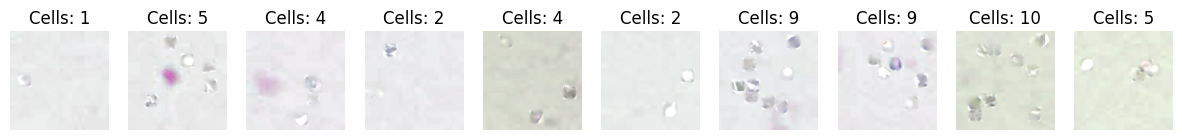

In [199]:
train_data = DataPreloading(num_samples=10).get_train_data()
# 5. Визуализация
import matplotlib.pyplot as plt

def visualize_data(images, labels, num_samples=10):
    """Визуализирует несколько случайных изображений из набора данных."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(f"Cells: {labels[i]}")
        axes[i].axis('off')
    plt.show()

visualize_data(train_data.images, train_data.labels)

In [ ]:
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class DataSelectionEnv(gymnasium.Env):
    def __init__(self):
        super(DataSelectionEnv, self).__init__()
        self.train_data = DataPreloading(num_samples=NUM_IMAGES).get_train_data()
        train_dataset_save = './blood_set_gen/train/images'
        
        metadata_to_save = []

        for i, (image_rgb, label) in enumerate(zip(self.train_data.images, self.train_data.labels)):
            filename = f"image_{i:06d}.png"
            filepath = os.path.join(train_dataset_save, filename)
            try:
                image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
                success = cv2.imwrite(filepath, image_bgr)
                if success:
                    metadata_to_save.append([filename, label])
                else:
                    print(f"Warning: Не удалось сохранить изображение {filepath}")
            except Exception as e:
                print(f"Ошибка при обработке/сохранении изображения {i}: {e}")

        print("Сохранение изображений завершено.")

        if metadata_to_save: # Проверяем, есть ли что сохранять
            try:
                with open('./blood_set_gen/train/labels', 'w', newline='') as f:
                    import csv
                    writer = csv.writer(f)
                    writer.writerow(['filename', 'label']) # Пишем заголовок
                    writer.writerows(metadata_to_save) # Пишем все строки [имя, метка]
                print("Сохранение меток завершено.")
            except Exception as e:
                print(f"Ошибка при сохранении файла меток: {e}")
        else:
            print("Нет данных для сохранения меток (возможно, были ошибки при сохранении изображений).")
            
        #self.model = SimpleCNN().to(DEVICE) 
        self.model = models.resnet18(weights=None)
        # Получаем количество входных признаков для последнего слоя ResNet18
        num_ftrs = self.model.fc.in_features

        # Создаем новый последний слой с нужным количеством выходов
        self.model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
        print(f"Последний слой ResNet18 заменен на nn.Linear({num_ftrs}, {NUM_CLASSES})")
        self.model = self.model.to(DEVICE)
        print(f"---CNN модель будет обучаться на устройстве {DEVICE}")
        self.criterion = nn.CrossEntropyLoss()
        self.indexes = self.class_select()
        self.optim = optim.Adam(self.model.parameters(), lr=LEARNING_RATE,weight_decay=1e-5) #пробовал добавлять weight_decay

        # Пространство действий: вероятности выбора изображений для каждого класса
        self.action_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)
        self.observation_space = gymnasium.spaces.Box(low=0, high=1, shape=(NUM_CLASSES,), dtype=np.float32)

        #validation set
        self.validation_indices = random.sample(range(len(self.train_data)), int(0.2 * len(self.train_data)))
        self.validation_subset = Subset(self.train_data, self.validation_indices)
        self.validation_dataloader = get_dataloader(self.validation_subset, shuffle=False,batch_sz=16)

    def class_select(self):#возвращаем словарь из индексов принадлежащим классам
        ls = {i: [] for i in range(NUM_CLASSES)} #создали пустой словарь на 10 классов

        for x, (image, label) in enumerate(self.train_data): #unpack both
            label_value = label.item()-1 #значения меток начинаются с 1, а индексация с 0
            ls[label_value].append(x) #индекс каждого изображения из train_data положили в нужный класс в зависимости от метки

        return ls

    def sample(self, action):#action - тензор распределения процентов изображений от каждого класса в выборке
        action = np.clip(action, 0, 1) #clip the action
        action = action / np.sum(action) #renormalize to ensure sum = 1
        index = []

        for i in range(NUM_CLASSES):
            num_img = int(action[i] * MAX_SUBSET_SIZE) #определили количество изображений для i-го класса в выборке из batch_size изображений
            indexes = np.random.choice(self.indexes[i], num_img, replace=True) #рандомно выбираем вычисленное количество изображений из изображений нужного класса, возвращаем их индексы
            index.extend(indexes)#добавляем найденные индексы в выборку

        return Subset(self.train_data, index)#состовляем subset

    def step(self, action,weights):
        # в этой функции мы создаем выборку на основе action и проверяем, насколько улучшилось или ухудшилось предсказание сети
        #action = np.clip(action + np.random.uniform(-0.05, 0.05, size=action.shape), 0, 1)
        train_subset = self.sample(action) #subset - выбранное случайное подмножество из 32 элементов на основе распределения action
        train_dataloader = get_dataloader(train_subset) #создали dataloader, выдающий этот batch из 32 элементов
        #prev_acc, _ = self.evaluate(test_dataloader) #вычиляем текущую точность модели на тестовой выборке
        self.train_model(train_dataloader, epochs=CNN_EPOCHS) #тренируем модель на тренировчной выборке
        _, err_per_cl = self.evaluate(self.validation_dataloader)  # Теперь возвращается точность по классам
        
        reward = np.sum([(1- err_per_cl[i])*weights[i] for i in range(NUM_CLASSES)])
        #reward = new_acc - self.last_acc #Предыдущая награда

        return reward, err_per_cl

    def train_model(self, dataloader, epochs=1):
        # на вход приходит dataloader выдающий batch изображений и ответов к ним
        self.model.train()#Необходимо переводить в train
        for epoch in range(epochs):
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                self.optim.zero_grad() #обновили optimizer
                output = self.model(images) #получили тензор(batch_size, NUM_CLASSES) с распределением вероятностей для каждого изображения
                
                loss = self.criterion(output, labels-1) #вычислили ошибку с помощью CrossEntropyLoss\
                print("loss = ", loss)
                loss.backward()
                self.optim.step()



    def evaluate(self, dataloader):
        self.model.eval()  # Переводим модель в оценочный режим
        correct = 0
        total = 0
        ls = torch.zeros(NUM_CLASSES, dtype=torch.int64, device=DEVICE)
        ers = torch.zeros(NUM_CLASSES, dtype=torch.int64, device=DEVICE)

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = self.model(images)  # Получили тензор(batch_size,NUM_CLASSES)
                predicted = torch.argmax(output, dim=1)+1  # Получили тезор(batch_size)
                correct += (predicted == labels).sum().item()  # Нашли количество правильных ответов
                total += labels.size(0) 

                # Обновляем ls и ers
                for i in range(NUM_CLASSES):
                    ls[i] += (labels == i+1).sum()
                    ers[i] += ((labels == i+1) & (predicted != labels)).sum()

        # Вычисляем error_per_class, обрабатывая деление на ноль
        error_per_class = [(ers[i].float() / ls[i].float()).item() if ls[i] > 0 else 0 for i in range(NUM_CLASSES)]
        accuracy = (correct / total) if total > 0 else 0  # Находим точность на данной выборке
        print("accuracy = ", accuracy)
        return accuracy, error_per_class


In [ ]:
Transition = namedtuple('Transition',('state','action','next_state','reward'))

class replay_memory(object):
    def __init__(self,capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)  

In [ ]:
def calculate_class_values(error_per_class):#функция для вычисления весов классов по ошибке на них
    """Вычисляет ценность классов на основе ошибок."""
    class_values = [min(1.0 / (1 - error + 1e-6), 10) for error in error_per_class]  # Избегаем деления на 0
    return class_values

In [ ]:
def actor_critic(env, actor, critic, episodes=10, max_steps=100, gamma=0.99,
                 lr_actor=1e-4, lr_critic=1e-4, 
                 entropy_coeff=0.01,           # Коэффициент для энтропийного бонуса
                 patience=30,                  # Терпение для ранней остановки
                 eval_freq=20):                # Частота оценки на тестовой выборке
    
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)

    actor.to(DEVICE)
    critic.to(DEVICE)
    memory = replay_memory(10000) # Буфер воспроизведения
    save_path = "last_model_checkpoint.pth"
    save_best_path = "best_model_checkpoint.pth"

    if hasattr(env, 'validation_dataloader') and env.validation_dataloader is not None:
         test_dataloader = env.validation_dataloader
         print("Используется validation_dataloader из среды для оценки.")
    else:
        print("Создание отдельного тестового набора данных для оценки...")
        test_dataset_full = DataPreloading(num_samples=max(NUM_IMAGES // 5, 2000)).get_train_data() # Берем часть данных для теста
        test_indices = random.sample(range(len(test_dataset_full)), int(0.2 * len(test_dataset_full))) # 20% от этого
        test_subset = Subset(test_dataset_full, test_indices)
        test_dataloader = get_dataloader(test_subset,shuffle=False,batch_sz=16)
        print(f"Размер тестового набора: {len(test_subset)} изображений.")
        # Убедимся, что среда использует свой валидационный набор для вычисления ошибки по классам
        if not hasattr(env, 'validation_dataloader') or env.validation_dataloader is None:
             print("ВНИМАНИЕ: У среды нет фиксированного validation_dataloader. Ошибка по классам может вычисляться на разных данных!")


    steps_done = 0
    best_test_accuracy = -1.0 
    no_improvement_steps = 0
    best_model_state = None

    print("Инициализация начального состояния (оценка на валидационном наборе)...")
    env.model.eval() # Переводим CNN в режим оценки
    _, initial_errors = env.evaluate(env.validation_dataloader) # Используем валидационный набор среды
    initial_state = np.array(initial_errors, dtype=np.float32)
    print(f"Начальное состояние (ошибки по классам): {initial_state}")


    for episode in range(episodes):
        # state = np.ones(NUM_CLASSES, dtype=np.float32) / NUM_CLASSES # Старая инициализация
        state = initial_state if episode == 0 else next_state # Используем вычисленное начальное или из пред. шага
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE) # Добавляем batch dimension

        for step in range(max_steps):
            steps_done += 1

            # --- Выбор действия ---
            epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            action_source = ""
            if random.random() < epsilon:
                # Исследование: Используем распределение Дирихле для генерации случайных пропорций
                action = np.random.dirichlet(np.ones(NUM_CLASSES)).astype(np.float32)
                action_source = "случайное (Dirichlet)"
            else:
                actor.eval() # Переводим Actor в режим оценки для выбора действия
                with torch.no_grad():
                    # state_tensor уже имеет batch dimension [1, NUM_CLASSES]
                    action_probabilities = actor(state_tensor)
                actor.train() # Возвращаем Actor в режим обучения
                action = action_probabilities.squeeze(0).cpu().numpy() # Убираем batch dimension
                action_source = "агент"

            # Обеспечим, чтобы сумма была 1 (из-за возможных ошибок округления)
            action = np.clip(action, 0, 1)
            action = action / np.sum(action)

            print(f"Эпизод: {episode+1}/{episodes}, Шаг: {step+1}/{max_steps}, Epsilon: {epsilon:.4f}")
            print(f"Текущее состояние (ошибки): {state}")
            print(f"Действие ({action_source}): {action}")

            # --- Взаимодействие со средой ---
            # Среда обучает CNN и возвращает reward и новое состояние (ошибки по классам)
            weights = calculate_class_values(state) # Веса на основе ТЕКУЩЕГО состояния
            print(f"Веса для классов: {weights}")
            # Передаем действие (numpy array) и веса в среду
            reward, next_state_errors = env.step(action, weights)
            next_state = np.array(next_state_errors, dtype=np.float32) # Преобразуем в numpy array

            print(f"Награда: {reward:.4f}, Новое состояние (ошибки): {next_state}")

            reward_tensor = torch.tensor([reward], dtype=torch.float32).to(DEVICE)
            action_tensor = torch.FloatTensor(action).to(DEVICE) # Без batch dimension
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(DEVICE) # Добавляем batch dimension

            # state_tensor был [1, NUM_CLASSES], убираем batch dimension перед сохранением
            memory.push(state_tensor.squeeze(0), action_tensor, next_state_tensor.squeeze(0), reward_tensor)

            state = next_state
            state_tensor = next_state_tensor # Обновляем state_tensor для следующего шага

            # --- Обучение Агента (если достаточно данных в буфере) ---
            if len(memory) >= BATCH_SIZE: # Начинаем обучение только при полном батче
                transitions = memory.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions))

                # Преобразуем батч в тензоры
                # state_batch и next_state_batch будут [BATCH_SIZE, NUM_CLASSES]
                state_batch = torch.stack(batch.state).to(DEVICE)
                action_batch = torch.stack(batch.action).to(DEVICE) # [BATCH_SIZE, NUM_CLASSES]
                reward_batch = torch.cat(batch.reward).to(DEVICE)   # [BATCH_SIZE]
                next_state_batch = torch.stack(batch.next_state).to(DEVICE)

                # --- Обучение Critic ---
                critic.train() # Убедимся, что Critic в режиме обучения
                # Текущее значение состояния V(s)
                current_values = critic(state_batch).squeeze() # [BATCH_SIZE]
                # Значение следующего состояния V(s')
                with torch.no_grad(): # Не обновляем Critic на основе будущих значений
                    next_values = critic(next_state_batch).squeeze() # [BATCH_SIZE]

                # Вычисляем TD target: R + gamma * V(s')
                td_target = reward_batch + gamma * next_values
                # Вычисляем Advantage: A(s,a) = TD target - V(s)
                advantage = td_target - current_values

                # Лосс Critic: минимизируем ошибку предсказания (MSE или Huber loss)
                loss_critic = F.mse_loss(current_values, td_target.detach()) # Отсоединяем target
                # loss_critic = F.smooth_l1_loss(current_values, td_target.detach()) # Huber loss - более робастный

                optimizer_critic.zero_grad()
                loss_critic.backward()
                optimizer_critic.step()

                # --- Обучение Actor ---
                actor.train() # Убедимся, что Actor в режиме обучения
                # Получаем логиты или log_softmax от Actor'а для текущих состояний
                action_log_probs_all = F.log_softmax(actor(state_batch), dim=1) # [BATCH_SIZE, NUM_CLASSES]

                # --- ИСПРАВЛЕННЫЙ ЛОСС ACTOR'а ---
                # Вместо gather с argmax, используем advantage для взвешивания log_probs
                # Мы хотим увеличить log_probs для действий, которые привели к высокому advantage
                # Умножаем каждый log_prob на advantage (отсоединенный)
                # advantage.detach().unsqueeze(1) преобразует [BATCH_SIZE] в [BATCH_SIZE, 1] для broadcast'а
                loss_actor_policy = -(action_log_probs_all * advantage.detach().unsqueeze(1)).mean()

                # --- Энтропийный бонус ---
                # Поощряем исследование, добавляя энтропию к лоссу (со знаком минус, т.к. минимизируем)
                action_probs_all = F.softmax(actor(state_batch), dim=1)
                entropy = -torch.sum(action_probs_all * torch.log(action_probs_all + 1e-6), dim=1).mean()
                loss_actor = loss_actor_policy - entropy_coeff * entropy

                optimizer_actor.zero_grad()
                loss_actor.backward()
                # torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0) # Опционально: клиппинг градиентов
                optimizer_actor.step()

                # print(f"    Loss Critic: {loss_critic.item():.4f}, Loss Actor (Policy): {loss_actor_policy.item():.4f}, Entropy: {entropy.item():.4f}") # Детальный лог лоссов

            # --- Оценка и Ранняя Остановка ---
            if steps_done % eval_freq == 0:
                print("-" * 30)
                print(f"Оценка на шаге {steps_done} (Эпизод {episode+1}, Шаг {step+1})")
                env.model.eval() # Переводим CNN в режим оценки
                current_test_accuracy, _ = env.evaluate(test_dataloader) # Оцениваем на ТЕСТОВОМ наборе
                env.model.train() # Возвращаем CNN в режим обучения для среды
                print(f"Текущая Точность на Тесте: {current_test_accuracy:.4f}")

                if current_test_accuracy > best_test_accuracy:
                    best_test_accuracy = current_test_accuracy
                    no_improvement_steps = 0
                    print(f"*** Новая лучшая точность на тесте: {best_test_accuracy:.4f}. Сохранение модели... ***")
                    # Сохраняем состояние всех моделей и оптимизаторов
                    best_model_state = {
                        'actor_state_dict': copy.deepcopy(actor.state_dict()),
                        'critic_state_dict': copy.deepcopy(critic.state_dict()),
                        'actor_optimizer_state_dict': copy.deepcopy(optimizer_actor.state_dict()),
                        'critic_optimizer_state_dict': copy.deepcopy(optimizer_critic.state_dict()),
                        'cnn_state_dict': copy.deepcopy(env.model.state_dict()), # Сохраняем и CNN
                        'steps_done': steps_done,
                        'best_test_accuracy': best_test_accuracy
                    }
                    try:
                            torch.save(best_model_state, save_best_path) # Сохраняем лучший на диск
                            print(f"*** ЛУЧШАЯ модель успешно сохранена в {save_best_path} ***")
                    except Exception as e:
                        print(f"ОШИБКА при сохранении ЛУЧШЕЙ модели на шаге {steps_done}: {e}")
                else:
                    no_improvement_steps += 1
                    print(f"Точность не улучшилась. Шагов без улучшения: {no_improvement_steps}/{patience}")

                if no_improvement_steps >= patience:
                    print(f"Ранняя остановка! Нет улучшений на тестовой выборке в течение {patience} * {eval_freq} шагов.")
                    # Загружаем лучшую найденную модель
                    if best_model_state is not None:
                        print("Восстановление лучшей модели...")
                        actor.load_state_dict(best_model_state['actor_state_dict'])
                        critic.load_state_dict(best_model_state['critic_state_dict'])
                        optimizer_actor.load_state_dict(best_model_state['actor_optimizer_state_dict'])
                        optimizer_critic.load_state_dict(best_model_state['critic_optimizer_state_dict'])
                        env.model.load_state_dict(best_model_state['cnn_state_dict'])
                        steps_done = best_model_state['steps_done'] # Можно восстановить и шаги
                        print(f"Лучшая модель восстановлена (Точность: {best_model_state['best_test_accuracy']:.4f})")
                    else:
                         print("Не найдено лучшей модели для восстановления.")
                    return # Завершаем обучение полностью

                print("-" * 30)

        # В конце эпизода можно добавить дополнительную логику, если нужно
        print(f"Конец Эпизода {episode+1}")

    # Если ранняя остановка не сработала, загружаем лучшую модель после всех эпизодов
    print("\nОбучение завершено по окончанию всех эпизодов.")

    # +++ ДОБАВЛЕНО: СОХРАНЕНИЕ ПОСЛЕДНЕГО СОСТОЯНИЯ МОДЕЛЕЙ +++
    print(f"Сохранение последнего состояния моделей в файл: {save_path}")
    last_model_state = {
        'cnn_state_dict': env.model.state_dict(), # Берем текущее состояние
        'actor_state_dict': actor.state_dict(),
        'critic_state_dict': critic.state_dict(),
        'actor_optimizer_state_dict': optimizer_actor.state_dict(), # Сохраним и оптимизаторы
        'critic_optimizer_state_dict': optimizer_critic.state_dict(),
        'steps_done': steps_done, # Сохраним шаг, на котором закончили
        # Можно сохранить и последнюю точность на тесте, если хотите
        # 'last_test_accuracy': current_test_accuracy if 'current_test_accuracy' in locals() else -1.0
    }
    try:
        torch.save(last_model_state, save_path)
        print(f"*** Последнее состояние моделей успешно сохранено в {save_path} ***")
    except Exception as e:
        print(f"ОШИБКА при сохранении последней модели: {e}")
    # +++ КОНЕЦ ДОБАВЛЕННОГО БЛОКА +++

    print(f"\n--- Обучение завершено ---")
    return last_model_state # Возвращаем словарь с последним состоянием



In [ ]:
env = DataSelectionEnv()
actor = Actor(NUM_CLASSES, NUM_CLASSES)
critic = Critic(NUM_CLASSES)


visualize_data(env.train_data.images, env.train_data.labels)

actor_critic(env, actor, critic, episodes=10)
print("Training complete!")